In [6]:
import pprint
from util.util_funcs import load_json, load_jsonl
import os, sys, argparse
from tqdm import tqdm
from util.util_funcs import replace_entities

DIR_PATH = os.path.abspath(os.getcwd())
FEVEROUS_PATH = DIR_PATH + "/FEVEROUS/src"
sys.path.insert(0, FEVEROUS_PATH)

from database.feverous_db import FeverousDB
from utils.wiki_page import WikiPage

db_path = "data/feverous_wikiv1.db"
db = FeverousDB(db_path)

pp = pprint.PrettyPrinter(indent=2)

sent_ret_acc = load_json("data/dev/sent_retrieval_acc.json")
top_docs = load_jsonl("data/dev/top_docs.jsonl")

In [23]:
no_match_samples = sent_ret_acc["no_match_samples"]
merged_data = []
for sample in no_match_samples:
    ret_docs = [d["docs"] for d in top_docs if d["claim"] == sample["claim"]]
    merged_obj = sample
    merged_obj["top_docs"] = ret_docs[0]
    merged_data.append(merged_obj)

pp.pprint(merged_data[:5])

[ { 'claim': '2014 Sky Blue FC season number 18 Lindsi Cutshall (born October '
             '18, 1990) played the FW position.',
    'evidence_sents': ['2014 Sky Blue FC season_sentence_6'],
    'related_sents': [ 'Lindsi Cutshall_sentence_0',
                       'Sky Blue FC_sentence_82',
                       'Sky Blue FC_sentence_68',
                       '2014 Sky Blue FC season_sentence_0',
                       'Sky Blue FC_sentence_50'],
    'sent_id_text_map': { '2014 Sky Blue FC season_sentence_0': 'The 2014 Sky '
                                                                'Blue FC '
                                                                'season was '
                                                                "the team's "
                                                                'fifth season '
                                                                'of existence.',
                          '2014 Sky Blue FC season_sentence_6': 'Key to

In [24]:
no_matched_samples_with_correct_docs = []
for sample in merged_data:
    match = False
    for doc in sample["top_docs"]:
        for sent in sample["evidence_sents"]:
            if doc in sent:
                match = True
    if match:
        no_matched_samples_with_correct_docs.append(sample)
                
pp.pprint(no_matched_samples_with_correct_docs[:5])

[ { 'claim': '2014 Sky Blue FC season number 18 Lindsi Cutshall (born October '
             '18, 1990) played the FW position.',
    'evidence_sents': ['2014 Sky Blue FC season_sentence_6'],
    'related_sents': [ 'Lindsi Cutshall_sentence_0',
                       'Sky Blue FC_sentence_82',
                       'Sky Blue FC_sentence_68',
                       '2014 Sky Blue FC season_sentence_0',
                       'Sky Blue FC_sentence_50'],
    'sent_id_text_map': { '2014 Sky Blue FC season_sentence_0': 'The 2014 Sky '
                                                                'Blue FC '
                                                                'season was '
                                                                "the team's "
                                                                'fifth season '
                                                                'of existence.',
                          '2014 Sky Blue FC season_sentence_6': 'Key to

In [25]:

for sample in tqdm(no_matched_samples_with_correct_docs):
    sent_id_text_map = {}
    for sent in sample["evidence_sents"]+sample["related_sents"]:
        sent_split = sent.split("_")
        doc_json = db.get_doc_json(sent_split[0])
        page = WikiPage(doc_json["title"], doc_json)
        sent_id = "_".join(sent_split[1:])
        sent_content = page.get_element_by_id(sent_id).content
        sent_id_text_map[sent] = replace_entities(sent_content)
    
    sample["sent_id_text_map"] = sent_id_text_map

pp.pprint(no_matched_samples_with_correct_docs[:5])


100%|█████████████████████████████████████████████████| 1046/1046 [00:09<00:00, 115.95it/s]

[ { 'claim': '2014 Sky Blue FC season number 18 Lindsi Cutshall (born October '
             '18, 1990) played the FW position.',
    'evidence_sents': ['2014 Sky Blue FC season_sentence_6'],
    'related_sents': [ 'Lindsi Cutshall_sentence_0',
                       'Sky Blue FC_sentence_82',
                       'Sky Blue FC_sentence_68',
                       '2014 Sky Blue FC season_sentence_0',
                       'Sky Blue FC_sentence_50'],
    'sent_id_text_map': { '2014 Sky Blue FC season_sentence_0': 'The 2014 Sky '
                                                                'Blue FC '
                                                                'season was '
                                                                "the team's "
                                                                'fifth season '
                                                                'of existence.',
                          '2014 Sky Blue FC season_sentence_6': 'Key to

In [20]:
labelled_data = load_jsonl("train_data/dev.jsonl")

claim = "GT cars are divided into 2 or 3 subgroups (GT3, GT4, and GT"
d = [d for d in labelled_data if claim in d["claim"]][0]
del d["annotator_operations"]
pp.pprint(d)

{ 'claim': 'GT cars are divided into 2 or 3 subgroups (GT3, GT4, and GT Open), '
           'on the other hand, TC, which are heavily modified road-going cars '
           'used in motorsport road racing competitions, are divided by '
           'calculated engine capacity (TC1 - TC4).',
  'evidence': [ { 'content': [ 'Group GT3_sentence_0',
                               'GT4 European Series_sentence_0',
                               'International GT Open_sentence_0'],
                  'context': { 'GT4 European Series_sentence_0': [ 'GT4 '
                                                                   'European '
                                                                   'Series_title'],
                               'Group GT3_sentence_0': ['Group GT3_title'],
                               'International GT Open_sentence_0': [ 'International '
                                                                     'GT '
                                                 

# Confusion Matrix

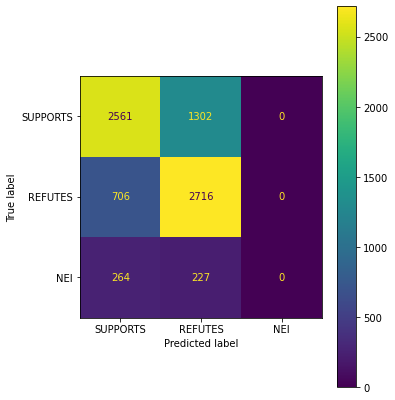

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from util.util_funcs import load_json, LABEL_TO_IDX
import matplotlib.pyplot as plt  

veracity_prediction = load_json("data/dev/veracity_prediction_accuracy.json")

all_correct_labels = veracity_prediction["all_correct_labels"]
all_predicted_labels = veracity_prediction["all_predicted_labels"]

y_true = [LABEL_TO_IDX[label] for label in all_correct_labels]
y_pred = [LABEL_TO_IDX[label] for label in all_predicted_labels]
#labels = list(LABEL_TO_IDX.keys())
labels = ["SUPPORTS", "REFUTES", "NEI"]

confusion_mat = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,
                              display_labels=labels)

fig, ax = plt.subplots(figsize=(7,7))
fig.subplots_adjust(left=0.3) # or whatever
#fig.tight_layout()
#plt.subplots_adjust(left=1, bottom=0, right=5, top=3, wspace=0, hspace=0)

disp.plot(ax=ax)
plt.savefig("data/dev/confusion_mat.png")
#plt.show()